# Case Study - SD

In [38]:
import numpy as np
import pandas as pd
import xgboost as xgb
import joblib
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve, plot_roc_curve
from xgboost import plot_importance
from matplotlib import pyplot

### Load Data

In [39]:
df = pd.read_csv('ds_practical.txt', delimiter = "|")

In [40]:
df.head()

,anon_person_id,target,state,presence_of_child_ind,streaming_media_subs,streaming_entertainment_subs,marital_status,gender,income,number_of_news_subs,age
0,1,0,CA,0,N,0,M,Female,$175k-199k,0,43.0
1,2,0,CA,0,N,0,U,Male,$225k-249k,0,90.0
2,3,1,CA,0,Y,1,S,Female,$150k-174k,0,46.0
3,4,0,CA,1,N,0,U,Female,$125k-149k,0,25.0
4,5,0,CA,0,N,0,U,Female,$175k-199k,0,62.0


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 11 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   anon_person_id                1000000 non-null  int64  
 1   target                        1000000 non-null  int64  
 2   state                         989976 non-null   object 
 3   presence_of_child_ind         1000000 non-null  int64  
 4   streaming_media_subs          1000000 non-null  object 
 5   streaming_entertainment_subs  1000000 non-null  int64  
 6   marital_status                1000000 non-null  object 
 7   gender                        1000000 non-null  object 
 8   income                        1000000 non-null  object 
 9   number_of_news_subs           1000000 non-null  int64  
 10  age                           980298 non-null   float64
dtypes: float64(1), int64(5), object(5)
memory usage: 83.9+ MB


### Data Cleaning

In [42]:
#State and age are missing for some observations based on df.info() above
#cannot infer their values based on the other attributes, so will have to drop them.
#Actually, XGBoost can handle missing values in estimation, however since I will also 
#estimate a logistic regression as a benchmark on the same data, for fair performance comparison,
#(on the same dataset), the missing values are dropped here. 

In [43]:
df.isnull().sum()

anon_person_id                      0
target                              0
state                           10024
presence_of_child_ind               0
streaming_media_subs                0
streaming_entertainment_subs        0
marital_status                      0
gender                              0
income                              0
number_of_news_subs                 0
age                             19702
dtype: int64

In [44]:
df = df.dropna() #drops all rows with missing values

In [45]:
#check if there are duplicate entries

In [46]:
df = df.sort_values('anon_person_id')

In [47]:
df.head(10)

,anon_person_id,target,state,presence_of_child_ind,streaming_media_subs,streaming_entertainment_subs,marital_status,gender,income,number_of_news_subs,age
0,1,0,CA,0,N,0,M,Female,$175k-199k,0,43.0
999500,1,0,CA,0,N,0,M,Female,$175k-199k,0,43.0
999501,2,0,CA,0,N,0,U,Male,$225k-249k,0,90.0
1,2,0,CA,0,N,0,U,Male,$225k-249k,0,90.0
2,3,1,CA,0,Y,1,S,Female,$150k-174k,0,46.0
999502,3,1,CA,0,Y,1,S,Female,$150k-174k,0,46.0
3,4,0,CA,1,N,0,U,Female,$125k-149k,0,25.0
999503,4,0,CA,1,N,0,U,Female,$125k-149k,0,25.0
4,5,0,CA,0,N,0,U,Female,$175k-199k,0,62.0
999504,5,0,CA,0,N,0,U,Female,$175k-199k,0,62.0


In [48]:
df.duplicated()

0         False
999500     True
999501    False
1          True
2         False
          ...  
999495    False
999496    False
999497    False
999498    False
999499    False
Length: 970470, dtype: bool

In [49]:
df = df.drop_duplicates() #drop subsequent duplicate rows 

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 970071 entries, 0 to 999499
Data columns (total 11 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   anon_person_id                970071 non-null  int64  
 1   target                        970071 non-null  int64  
 2   state                         970071 non-null  object 
 3   presence_of_child_ind         970071 non-null  int64  
 4   streaming_media_subs          970071 non-null  object 
 5   streaming_entertainment_subs  970071 non-null  int64  
 6   marital_status                970071 non-null  object 
 7   gender                        970071 non-null  object 
 8   income                        970071 non-null  object 
 9   number_of_news_subs           970071 non-null  int64  
 10  age                           970071 non-null  float64
dtypes: float64(1), int64(5), object(5)
memory usage: 88.8+ MB


In [51]:
df['gender'].unique()

array(['Female', 'Male', 'feMalee'], dtype=object)

In [52]:
df['gender'] = df['gender'].replace('feMalee', 'Female')

In [53]:
df['gender'].unique()

array(['Female', 'Male'], dtype=object)

### Data Preparation

In [54]:
df_x_partial = df[['presence_of_child_ind', 'streaming_entertainment_subs', 'number_of_news_subs', 'age']]

In [55]:
#one-hot encode the categorical variables:

In [56]:
df_x_categorical = df[['state', 'streaming_media_subs', 'marital_status', 'gender', 'income']]

In [57]:
one_hot_x=pd.get_dummies(df_x_categorical)

In [58]:
# < symbol in column name will lead to an error in XGBoost, hence correct for that:
one_hot_x = one_hot_x.rename(columns={'income_<$25k': 'income_Less$25k'})

In [59]:
# For XGBoost, prepare Y and X features
# Since XGBoost can handle multicollinarity, there is no need to drop the trivial one-hot-encoded attributes

In [60]:
df_y = df[['target']]

In [61]:
df_x = pd.concat([df_x_partial,one_hot_x],axis=1)

In [62]:
# For Logistic Regression, prepare Y and X features
# Since dummy variable trap is a concern for the Logistic Regression, I will drop one column out of 
# every one-hot-encoded variable. These dropped columns will define the baseline and the coefficients 
# obtained will represent the contributions to the probability compared to the baseline.

In [63]:
df_y_logistic = df[['target']]

In [64]:
one_hot_x.head()

,state_CA,state_DC,state_GA,streaming_media_subs_N,streaming_media_subs_Y,marital_status_M,marital_status_S,marital_status_U,gender_Female,gender_Male,...,income_$150k-174k,income_$175k-199k,income_$200k-224k,income_$225k-249k,income_$250k+,income_$25k-49k,income_$50k-74k,income_$75k-99k,income_Less$25k,income_U
0,1,0,0,1,0,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
999501,1,0,0,1,0,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0
2,1,0,0,0,1,0,1,0,1,0,...,1,0,0,0,0,0,0,0,0,0
3,1,0,0,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,0,0,0,0,0


In [65]:
one_hot_x_logistic = one_hot_x.drop(['state_GA', 'streaming_media_subs_N', 'marital_status_U', 'gender_Male', 'income_U'], axis=1)

In [66]:
one_hot_x_logistic.head()

,state_CA,state_DC,streaming_media_subs_Y,marital_status_M,marital_status_S,gender_Female,income_$100k-124k,income_$125k-149k,income_$150k-174k,income_$175k-199k,income_$200k-224k,income_$225k-249k,income_$250k+,income_$25k-49k,income_$50k-74k,income_$75k-99k,income_Less$25k
0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0
999501,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,1,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0
3,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0


In [67]:
df_x_logistic = pd.concat([df_x_partial,one_hot_x_logistic],axis=1)

#  

# Predict the Probability of Listening Podcasts

### Machine Learning - XGBoost

In [31]:
def predict_podcast(Y_data=df_y, X_data=df_x):
    Y = Y_data
    X = X_data
    

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=101)
    
    xgb_model = XGBClassifier(objective = "binary:logistic")

    params = {'eta': [0.05, 0.1, 0.2],
            'min_child_weight': [11],
            'gamma': [0, 1],
            'lambda': [0, 10],
            'alpha': [0, 10],
            'max_depth': [3,4,5,6],
            'subsample': [0.8],
            'colsample_bytree': [0.8],
            'n_estimators': [800], 
            'seed': [101]
        }

    skf = StratifiedKFold(n_splits=5, shuffle=True)

    grid_model = GridSearchCV(xgb_model, 
                    param_grid = params, 
                    scoring = 'roc_auc', 
                    n_jobs = 4, 
                    cv = skf.split(X_train, Y_train),
                    verbose = 2,
                    refit = 'roc_auc')


    grid_model.fit(X_train, Y_train) 
    
    best_parameters = grid_model.best_params_
    print(best_parameters)
    best_model = grid_model.best_estimator_
    print(best_model)
    
    Y_pred = grid_model.predict(X_test)
    
    #save the model
    joblib.dump(grid_model.best_estimator_, 'best_model.pkl', compress = 1)   
    
    print(classification_report(Y_test, Y_pred))
    feature_importance = grid_model.best_estimator_.feature_importances_
    print(feature_importance)
    important_features = pd.DataFrame(index=X.columns, data=feature_importance, columns=['importance'])
    important_features = important_features.sort_values('importance', ascending=False)
    print(important_features)
    
    ac_score = accuracy_score(Y_test, Y_pred)
    print(ac_score)
    confusion_matrix(Y_test, Y_pred)
    plot_confusion_matrix(grid_model, X_test, Y_test)
    
    plot_precision_recall_curve(grid_model, X_test, Y_test)
    plot_roc_curve(grid_model, X_test, Y_test)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


/opt/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[02:52:37] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'alpha': 0, 'colsample_bytree': 0.8, 'eta': 0.05, 'gamma': 0, 'lambda': 0, 'max_depth': 3, 'min_child_weight': 11, 'n_estimators': 800, 'seed': 101, 'subsample': 0.8}
XGBClassifier(alpha=0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eta=0.05, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              lambda=0, learning_rate=0.0500000007, max_delta_step=0,
              max_depth=3, min_child_weight=11, missing=nan,
              monotone_constraints='()', n_estimators=800, n_jobs=8,
              num_parallel_tree=1, random

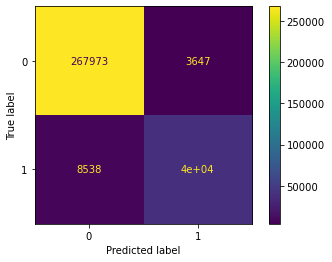

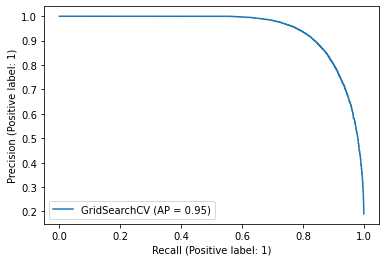

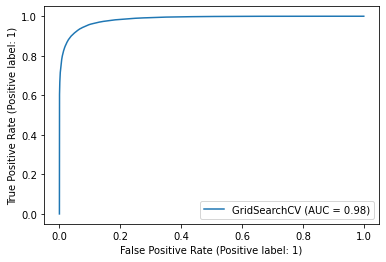

In [32]:
predict_podcast(Y_data=df_y, X_data=df_x)

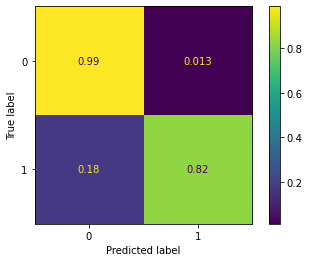

In [97]:
best_case=joblib.load('best_model.pkl')
Y = df_y
X = df_x
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=101)
# Scaled so highest value=1
plot_confusion_matrix(best_case,X_test,Y_test,normalize='true')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

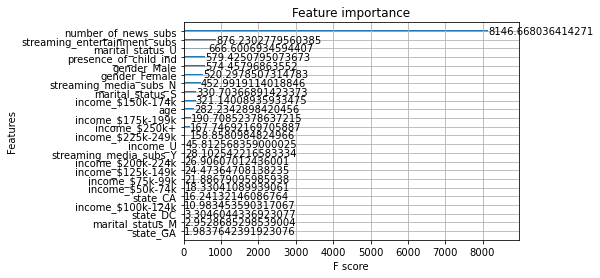

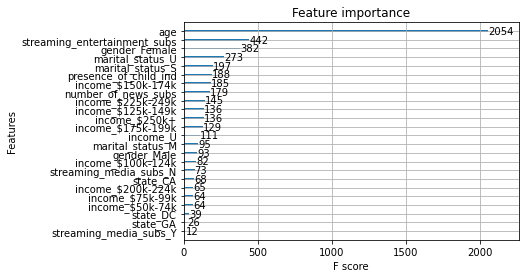

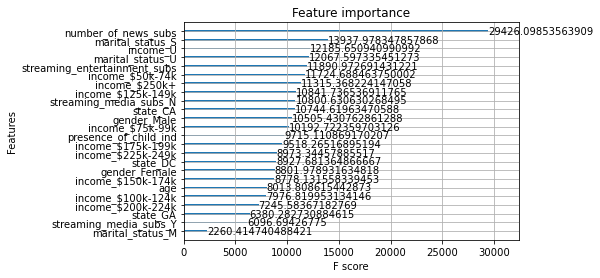

In [33]:
best_case=joblib.load('best_model.pkl')
xgb.plot_importance(best_case, importance_type='gain')
xgb.plot_importance(best_case, importance_type='weight')
xgb.plot_importance(best_case, importance_type='cover')

In [34]:
best_case.get_booster().get_score(importance_type='gain')
best_case.get_booster().get_score(importance_type='weight')
best_case.get_booster().get_score(importance_type='cover')

{'number_of_news_subs': 29426.09853563909,
 'streaming_entertainment_subs': 11890.972691431221,
 'marital_status_S': 13937.978347857868,
 'gender_Female': 8801.978931634818,
 'presence_of_child_ind': 9715.110869170207,
 'marital_status_U': 12067.597335451273,
 'age': 8013.808615442873,
 'gender_Male': 10505.430762861288,
 'income_$100k-124k': 7976.819953134146,
 'streaming_media_subs_N': 10800.630630268495,
 'income_$150k-174k': 8778.131558339453,
 'income_$225k-249k': 8973.34457885517,
 'income_$175k-199k': 9518.26516895194,
 'income_$250k+': 11315.368224147058,
 'marital_status_M': 2260.414740488421,
 'income_U': 12185.650940990992,
 'income_$200k-224k': 7245.58367182769,
 'streaming_media_subs_Y': 6096.69426775,
 'income_$125k-149k': 10841.736536911765,
 'income_$50k-74k': 11724.688463750002,
 'income_$75k-99k': 10192.722359703126,
 'state_CA': 10744.61963470588,
 'state_DC': 8927.681364866667,
 'state_GA': 6380.282730884615}

In [ ]:
# Potential improvements:
# Investigate SHAP values for further model explainability
# Expand the grid to cover more hyperparameters as the current best model's hyperparameters are on the border 
# of the current  grid & and do another round of grid search.

### Prepare submission data

In [35]:
print(np.shape(df_x))
test_case=joblib.load('best_model.pkl')
Y_pred_prob_all = test_case.predict_proba(df_x)  # probability that a person will [not listen, listen]
Probability = test_case.predict_proba(df_x)[:,1] # probability that a person will listen
Prediction = test_case.predict(df_x)             # 0-1 predicted outcomes based on 0.5 cutoff
Target = df_y

df = df.assign(target = Target)
df = df.assign(probability = Probability)
df = df.assign(prediction = Prediction)
df = df[['anon_person_id', 'target', 'prediction', 'probability']]
print(df.head(100))

# Submission
df.to_csv('Scores.csv', index=False)

(970071, 26)
        anon_person_id  target  prediction  probability
0                    1       0           1     0.608081
999501               2       0           0     0.000003
2                    3       1           1     0.993130
3                    4       0           0     0.000051
4                    5       0           0     0.001843
...                ...     ...         ...          ...
999595              96       0           0     0.040046
96                  97       0           0     0.000026
97                  98       0           0     0.001401
98                  99       0           0     0.000232
99                 100       0           0     0.004741

[100 rows x 4 columns]


In [36]:
pd.read_csv('Scores.csv')

,anon_person_id,target,prediction,probability
0,1,0,1,0.608081
1,2,0,0,0.000003
2,3,1,1,0.993130
3,4,0,0,0.000051
4,5,0,0,0.001843
...,...,...,...,...
970066,999496,0,0,0.000019
970067,999497,0,0,0.000024
970068,999498,0,0,0.001887
970069,999499,0,0,0.002343


In [ ]:
# Notes on 0.5 cutoff to convert probability into 1/0 tagging:
# 0.5 is preset and intuitive, however it might not be the best choice. 
# Other possible ways to assign the tagging:
# (1) Bernoulli distribution - try to infer 1/0 from a Bernoulli distribution with predicted probability
# For example, if the model predicts 30%, assign 1/0 based on RAND('Bernoulli', 0.3)
# (2) Pick a cutoff based on the sample: pick the cutoff such that the actual success rate
# equals predicted success rate on the sample (at what cutoff can this be achieved)
# (3) 0.5 preset cutoff used above
# One can then get 1/0 taggings based on each approach, 
# construct 3 confusion matrices to evaluate classification accuracy of
# actual vs. predicted success. Based on the confusion matrix, we can calculate:
# Precision, Recall, F1 Score, Accuracy
# and pick the best 1/0 assignment method based on these metrics. 

### Benchmark - Traditional Approach - Logistic Regression

In [ ]:
# A logistic regression is estimated as a benchmark to compare performance
# as well as to gain more insights into the key predictors.
# One should note the possibility of multicollinearity here, however.
# While dropping the one category from each one-hot-encoded variable prevented perfect multicollinearity,
# age is still likely correlated with income, child indicator, and marital status. 
# Correlated independent variables will violate the model assumptions
# and lead to biased coefficients along with unreliable p-values. 
# A more refined logistic regression model would conduct more feature engineering (such as age bins)
# and only include attributes with VIF<6. 
# Since this is a benchmark model for a POC, such details are not explored here.
# Main predictor model should be taken as the XGBoost model above.

In [98]:
Y = df_y_logistic
X = df_x_logistic

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=101)

In [69]:
from sklearn.preprocessing import StandardScaler

In [70]:
scaler = StandardScaler()

In [71]:
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [ ]:
# Estimate a quick model using statsmodels to easily get p-values

In [75]:
import statsmodels.api as sm
logit_model=sm.Logit(Y_train,scaled_X_train)
result=logit_model.fit(maxiter=200)
print(result.summary())
# based on the p values, we can see which coefficients are statistically significantly different than zero 
# at 95% confidence level

Optimization terminated successfully.
         Current function value: 0.141611
         Iterations 66
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:               649947
Model:                          Logit   Df Residuals:                   649927
Method:                           MLE   Df Model:                           19
Date:                Sun, 12 Sep 2021   Pseudo R-squ.:                  0.6658
Time:                        12:17:02   Log-Likelihood:                -92040.
converged:                       True   LL-Null:                   -2.7544e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             6.1959     56.102      0.110      0.912    -103.761     116.153
x2             0.4864   1.19

In [ ]:
# Also estimate a quick logistic using sklearn so that we can compare to the performance metrics of XGBoost above

In [72]:
from sklearn.linear_model import LogisticRegression

In [80]:
log_model = LogisticRegression(max_iter=1000)

In [81]:
log_model.fit(scaled_X_train, Y_train.values.ravel())

LogisticRegression(max_iter=1000)

In [82]:
log_model.coef_

array([[ 2.48429183,  0.4862172 ,  7.71410025, -0.17271763,  0.0843173 ,
        -0.04099076,  0.4862172 ,  0.69298843,  0.66998578,  0.96601844,
        -0.8091503 , -1.32547682,  1.28187756,  1.29296247,  0.97973663,
         0.56819906,  0.15171036, -0.04767991, -0.15349971, -0.39535376,
        -0.01688423]])

In [86]:
Y_pred=log_model.predict(X_test)

In [87]:
accuracy_score(Y_test, y_pred)

0.9284745910959503

In [89]:
confusion_matrix(Y_test,Y_pred)

array([[271620,      0],
       [ 22897,  25607]])

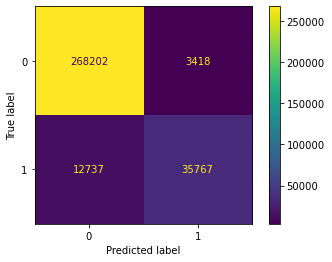

In [91]:
plot_confusion_matrix(log_model,scaled_X_test,Y_test)

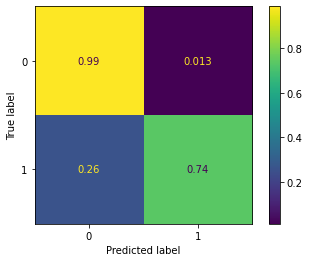

In [93]:
# Scaled so highest value=1
plot_confusion_matrix(log_model,scaled_X_test,Y_test,normalize='true')

In [96]:
print(classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96    271620
           1       1.00      0.53      0.69     48504

    accuracy                           0.93    320124
   macro avg       0.96      0.76      0.83    320124
weighted avg       0.93      0.93      0.92    320124



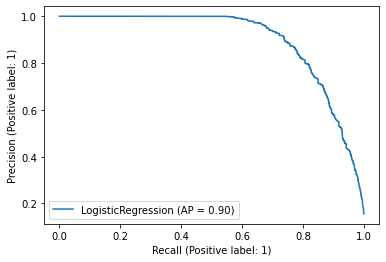

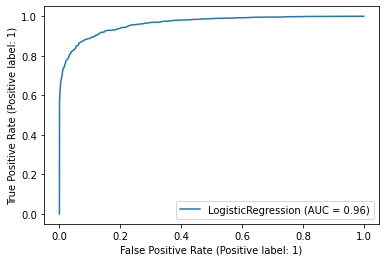

In [100]:
plot_precision_recall_curve(log_model, scaled_X_test, Y_test)
plot_roc_curve(log_model, scaled_X_test, Y_test)

# 